In [189]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
from scipy.stats import skew, kurtosis
# from jax import jit

In [190]:
# plot ellipse

def confidence_ellipse(mu, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0,0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1,0]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [228]:
def dynamics_step( base_term, state_dot, dt ):
    next_state = base_term + state_dot * dt
    return next_state

def dynamics_xdot(state, action = np.array([0])):
    return 20 * np.array([np.cos(state[0,0])+0.01, np.sin(state[1,0])+0.01]).reshape(-1,1)
#     return 20 * np.array([np.cos(state[0,0])+0.01, np.sin(state[1,0])+0.01]).reshape(-1,1)

# assume this is true dynamics
def dynamics_xdot_noisy(state, action = np.array([0])):
    xdot = dynamics_xdot(state, action)
    error_square = 0.01 + np.square(xdot) # /2  #never let it be 0!!!!
    cov = np.diag( error_square[:,0] )
    xdot = xdot + xdot/2 #X_dot = X_dot + X_dot/6
    return xdot, cov

In [224]:
# @jit
def get_mean( sigma_points, weights ):
    weighted_points = sigma_points * weights[0]
    mu = np.sum( weighted_points, 1 ).reshape(-1,1)
    return mu

# @jit
def get_mean_cov(sigma_points, weights):
    
    # mean
    weighted_points = sigma_points * weights[0]
    mu = np.sum( weighted_points, 1 ).reshape(-1,1)
    
    # covariance
    centered_points = sigma_points - mu
    weighted_centered_points = centered_points * weights[0] 
    cov = weighted_centered_points @ centered_points.T
    return mu, cov

# moments for data generation
# assume rows independent. therefore disginal eleemnts are 0. skewness and kurtosis only for 1-D data
def get_mean_cov_skew_kurt_for_generation( sigma_points, weights ):
    # mean
    weighted_points = sigma_points * weights[0]
    mu = np.sum( weighted_points, 1 ).reshape(-1,1)    
    centered_points = sigma_points - mu    
    # covariance
#     weighted_centered_points = centered_points * weights[0] 
#     cov = weighted_centered_points @ centered_points.T   
    cov = np.diag(np.sum(centered_points**2 * weights[0], axis=1))
    print(f"COV: {cov}")
    # Skewness times cov_root^-3
    skewness = np.sum(centered_points**3 * weights[0], axis=1) #/ cov[0,0]**(3/2) # for scipy    
    skewness[0] = skewness[0] / cov[0,0]**(3/2)
    skewness[1] = skewness[1] / cov[1,1]**(3/2)
    # kurtosis times cov_root^-4
    kurt = np.sum(centered_points**4 * weights[0], axis=1)# / cov[0,0]**(4/2)  # -3 # -3 for scipy
    kurt[0] = kurt[0]/cov[0,0]**(4/2)
    kurt[1] = kurt[1]/cov[1,1]**(4/2)
    return mu, cov, skewness.reshape(-1,1), kurt.reshape(-1,1)

# actual moments
def get_mean_cov_skew_kurt( sigma_points, weights ):
    # mean
    weighted_points = sigma_points * weights[0]
    mu = np.sum( weighted_points, 1 ).reshape(-1,1)    
    centered_points = sigma_points - mu    
    # covariance
#     weighted_centered_points = centered_points * weights[0] 
#     cov = weighted_centered_points @ centered_points.T    
    cov = np.diag(np.sum(centered_points**2 * weights[0], axis=1))
    # Skewness times cov_root^-3
    skewness = np.sum(centered_points**3 * weights[0], axis=1) #/ cov[0,0]**(3/2) # for scipy    
    # kurtosis times cov_root^-4
    kurt = np.sum(centered_points**4 * weights[0], axis=1) #/ cov[0,0]**(4/2)-3 # for scipy
    return mu, cov, skewness.reshape(-1,1), kurt.reshape(-1,1)

#@jit
def get_ut_cov_root_diagonal(cov):
    offset = 0.000  # TODO: make sure not zero here
    root0 = np.sqrt((offset+cov[0,0]))
    root1 = np.sqrt((offset+cov[1,1]))
    # return cov
    root_term = np.diag( np.array([root0, root1]) )
    return root_term

In [225]:
# sigma_points = np.array([[1, 2, 3, 4, 5],[1, 2, 3, 4, 5]])
# weights = np.ones((1,5))/5

sigma_points = np.array([[2, 8, 0, 4, 1, 9, 9, 0],[2, 8, 0, 4, 1, 9, 9, 0]])
weights = np.ones((1,8))/8
print(f"scipy: skew: {skew(sigma_points, axis=1)}, kurtosis: {kurtosis(sigma_points,axis=1)}")

print("\n")
mu, cov, skewness, kurt = get_mean_cov_skew_kurt( sigma_points, weights )
print(f"Actual:\n mu: {mu.T}, \n cov: {cov},\n skewness: {skewness},\n kurt: {kurt}")

print(f"\n")
mu, cov, skewness, kurt = get_mean_cov_skew_kurt_for_generation( sigma_points, weights )
print(f"for generation:\n mu: {mu.T}, \n cov: {cov},\n skewness: {skewness},\n kurt: {kurt}")
print(f"\n")

scipy: skew: [0.26505541 0.26505541], kurtosis: [-1.66600108 -1.66600108]


Actual:
 mu: [[4.125 4.125]], 
 cov: [[13.859375  0.      ]
 [ 0.       13.859375]],
 skewness: [[13.67578125]
 [13.67578125]],
 kurt: [[256.23754883]
 [256.23754883]]


COV: [[13.859375  0.      ]
 [ 0.       13.859375]]
for generation:
 mu: [[4.125 4.125]], 
 cov: [[13.859375  0.      ]
 [ 0.       13.859375]],
 skewness: [[0.26505541]
 [0.26505541]],
 kurt: [[1.33399892]
 [1.33399892]]




In [137]:
b = np.array([1,2,3])
c = np.array([1,2,3])
1 / c

array([1.        , 0.5       , 0.33333333])

# MC update

In [138]:
def mc_propagate(points):
    new_points = np.copy(points)
    for i in range(points.shape[1]):
        mu, cov = dynamics_xdot_noisy(points[:,i].reshape(-1,1))
        sample = np.array([  np.random.normal(mu[0,0], np.sqrt(cov[0,0])), np.random.normal(mu[1,0], np.sqrt(cov[1,1]))  ]).reshape(-1,1) 
        points[:,i] = dynamics_step(points[:,i].reshape(-1,1), sample, dt)[:,0]
    return points

# GenUT update

In [217]:
#@jit
def initialize_sigma_points(X):
    # return 2N + 1 points
    n = X.shape[0]
    num_points = 2*n + 1
    sigma_points = np.repeat( X, num_points, axis=1 )
    weights = np.ones((1,num_points)) * 1.0/( num_points )
    return sigma_points, weights

def generate_sigma_points_gaussian( mu, cov_root, base_term, factor ):
    n = mu.shape[0]     
    N = 2*n + 1 # total points

    # k = 1.0#0.5 # n-3 # 0.5**
    
    alpha = 1.0
    beta = 0.0#2.0#2.0 # optimal for gaussian
    k = 1.0
    Lambda = alpha**2 * ( n+k ) - n
    new_points = dynamics_step(base_term, mu, factor) # new_points = base_term + factor * mu
    new_weights = np.array([[1.0*Lambda/(n+Lambda)]])    
    new_weights_cov = np.array([[ 1.0*Lambda/(n+Lambda) + 1 - alpha**2 + beta]])
    for i in range(n):
#         print(f"new_points:{new_points}")
        new_points = np.append( new_points, dynamics_step(base_term, (mu - np.sqrt(n+Lambda) * cov_root[:,i].reshape(-1,1)), factor) , axis = 1 )
        new_points = np.append( new_points, dynamics_step(base_term, (mu + np.sqrt(n+Lambda) * cov_root[:,i].reshape(-1,1)), factor) , axis = 1 )
        new_weights = np.append( new_weights, np.array([[1.0/(n+Lambda)/2.0]]), axis = 1 )
        new_weights = np.append( new_weights, np.array([[1.0/(n+Lambda)/2.0]]), axis = 1 )
        new_weights_cov = np.append( new_weights_cov, np.array([[1.0/(n+Lambda)/2.0]]), axis = 1 )
        new_weights_cov = np.append( new_weights_cov, np.array([[1.0/(n+Lambda)/2.0]]), axis = 1 )
    # print(f"weights1: {new_weights}")
    # print(f"weights2: {new_weights_cov}")
    return new_points, new_weights

# @jit
def generate_sigma_points_gaussian_GenUT( mu, cov_root, skewness, kurt, base_term, factor ):
    n = mu.shape[0]     
    N = 2*n + 1 # total points
    
#     u = 0.5#k
    print(f"GENERATE mu: {mu}, cov_root:{cov_root}, skew:{skewness}, kurt:{kurt}")
#     cov_3 = np.diag(np.reciprocal(np.diagonal(cov_root**3)))
#     cov_4 = np.diag(np.reciprocal(np.diagonal(cov_root**4)))
    u = 0.5 * ( - skewness + np.sqrt( 4 * kurt - 3 * ( skewness )**2 ) )
    v = u + skewness
#     v = u + cov_3 @ skewness
#     print(f"cov_root:{cov_root}, \n 3: {cov_3}, \n 4: {cov_4}")
    print(f"u:{u.T},\n v:{v.T},\n term:{4 * kurt - 3 * ( skewness )**2} ")
    
    w2 = (1.0 / v) / (u+v)
    w1 = (w2 * v) / u
    w0 = 1 - np.sum(w1) - np.sum(w2)
    print(f"w0:{w0},\n w1:{w1},\n w2:{w2}")
    
#     k = 0.5 # n-3 # 0.5**
    new_points = dynamics_step(base_term, mu, factor) # new_points = base_term + factor * mu
    new_weights = np.array([[w0]])
    for i in range(n):
        new_points = np.append( new_points, dynamics_step(base_term, (mu - u[i,0]*cov_root[:,i].reshape(-1,1)), factor) , axis = 1 )
        new_points = np.append( new_points, dynamics_step(base_term, (mu + v[i,0]*cov_root[:,i].reshape(-1,1)), factor) , axis = 1 )
        new_weights = np.append( new_weights, np.array([[w1[i,0]]]), axis = 1 )
        new_weights = np.append( new_weights, np.array([[w2[i,0]]]), axis = 1 )
    return new_points, new_weights

# @jit
def sigma_point_expand(sigma_points, weights, control):
   
    n, N = sigma_points.shape   
    # dt_outer = 0  
    #TODO  
    mu, cov = dynamics_xdot_noisy(sigma_points[:,0].reshape(-1,1), control.reshape(-1,1))
    root_term = get_ut_cov_root_diagonal(cov) 
    temp_points, temp_weights = generate_sigma_points_gaussian( mu, root_term, sigma_points[:,0].reshape(-1,1), dt )
    new_points = np.copy( temp_points )
    new_weights = ( np.copy( temp_weights ) * weights[0,0]).reshape(1,-1)
        
    for i in range(1,N):
        mu, cov = dynamics_xdot_noisy(sigma_points[:,i].reshape(-1,1), control.reshape(-1,1))
        root_term = get_ut_cov_root_diagonal(cov)           
        temp_points, temp_weights = generate_sigma_points_gaussian( mu, root_term, sigma_points[:,i].reshape(-1,1), dt )
        new_points = np.append(new_points, temp_points, axis=1 )
        new_weights = np.append( new_weights, (temp_weights * weights[0,i]).reshape(1,-1) , axis=1 )

    return new_points, new_weights

#@jit
def sigma_point_compress( sigma_points, weights ):
    mu, cov = get_mean_cov( sigma_points, weights )
    cov_root_term = get_ut_cov_root_diagonal( cov )  
    base_term = np.zeros((mu.shape))
    return generate_sigma_points_gaussian( mu, cov_root_term, base_term, np.array([1.0]) )

#@jit
def sigma_point_compress_GenUT( sigma_points, weights ):
    mu, cov, skewness, kurt = get_mean_cov_skew_kurt_for_generation( sigma_points, weights )
    print(f"mu:{mu}, cov:{cov}, skewness:{skewness}, kurtosis:{kurt}")
    cov_root_term = get_ut_cov_root_diagonal( cov )  
    base_term = np.zeros((mu.shape))
    return generate_sigma_points_gaussian_GenUT( mu, cov_root_term, skewness, kurt, base_term, np.array([1.0]) )

# @jit
def foresee_propagate( sigma_points, weights, action = np.array([0]) ):
    
    #Expansion Layer
    expanded_sigma_points, expanded_weights = sigma_point_expand( sigma_points, weights, action )
    
    # Compression layer
#     compressed_sigma_points, compressed_weights = sigma_point_compress_GenUT(expanded_sigma_points, expanded_weights)
    compressed_sigma_points, compressed_weights = sigma_point_compress(expanded_sigma_points, expanded_weights)
    
    return compressed_sigma_points, compressed_weights, expanded_sigma_points, expanded_weights

# @jit
def foresee_propagate_GenUT( sigma_points, weights, action = np.array([0]) ):
    
    #Expansion Layer
    expanded_sigma_points, expanded_weights = sigma_point_expand( sigma_points, weights, action )
    
    # Compression layer
    compressed_sigma_points, compressed_weights = sigma_point_compress_GenUT(expanded_sigma_points, expanded_weights)
    
    return compressed_sigma_points, compressed_weights, expanded_sigma_points, expanded_weights

In [140]:
new_points, new_weights = generate_sigma_points_gaussian_GenUT(mu, get_ut_cov_root_diagonal(cov), skewness, kurt, np.zeros((2,1)), 1.0)

# get_mean_cov_skew_kurt(new_points, new_weights)
mu_after, cov_after, skewness_after, kurt_after = get_mean_cov_skew_kurt( new_points, new_weights )
print(f"\n from GenUT AFTER:\n mu: {mu_after.T}, \n cov: {cov_after},\n skewness: {skewness_after},\n kurt: {kurt_after}")


u:[[0.99942112 0.99942112]],
 v:[[1.26447653 1.26447653]],
 term:[[5.12523258]
 [5.12523258]] 
w0:-0.582598314688295,
 w1:[[0.44197193]
 [0.44197193]],
 w2:[[0.34932723]
 [0.34932723]]

 from GenUT AFTER:
 mu: [[4.125 4.125]], 
 cov: [[13.859375  0.      ]
 [ 0.       13.859375]],
 skewness: [[13.67578125]
 [13.67578125]],
 kurt: [[256.23754883]
 [256.23754883]]


In [141]:
705.61 / cov[0,0]**(1.5)

13.67569033408852

In [142]:
49218.69141942 / cov[0,0]**(2)

256.2375488281113

In [143]:
mu = np.array([0.075, 0.075]).reshape(-1,1)
cov = np.array([
    [0.00252, 0],
    [0.0, 0.00252]
])
mu = np.array([1.5]).reshape(-1,1)
cov = np.array([[0.6]])
cov_root = np.sqrt( cov )

points, weights = generate_sigma_points_gaussian( mu, cov_root, np.zeros((1,1)), 1.0 )
mu2, cov2 = get_mean_cov( points, weights )
print( f"mean:{mu2}, cov:{cov2}" )

# points, weights = generate_sigma_points_gaussian( mu, cov_root, np.zeros((1,1)), 1.0 )
# mu2, cov2 = get_mean_cov( points, weights )
# print( f"mean:{mu2}, cov:{cov2}" )

mean:[[1.5]], cov:[[0.6]]


In [144]:
points

array([[1.5       , 0.40455488, 2.59544512]])

# Test Scenario

In [229]:
horizon = 10
dt = 0.05
initial_state_mean = np.array([0.2,0.0]).reshape(-1,1)
initial_state_cov = np.zeros((2,2))
sigma_points_init, weights_init = initialize_sigma_points(initial_state_mean)

# PILCO init
pilco_mu, pilco_cov = np.copy(initial_state_mean), np.copy(initial_state_cov)

# Monte Carlo init
num_particles = 20000
mc_particles = np.repeat(initial_state_mean, num_particles, axis=1)

# FORESEE init
sigma_points = np.copy(sigma_points_init)
weights = np.copy(weights_init)
sigma_points_GenUT = np.copy(sigma_points_init)
weights_GenUT = np.copy(weights_init)

# Initialize data

for t in range(horizon):
    
#     # PILCO Update
#     pilco_mu, pilco_cov = pilco_propagate(pilco_mu, pilco_cov)

    # Monte Carlo Update
    mc_particles = mc_propagate(mc_particles)    
    
    # FORESEE update
    sigma_points, weights, full_sigma_points, full_weights = foresee_propagate(sigma_points, weights)
    
    # FORESEE GenUT update
    sigma_points_GenUT, weights_GenUT, full_sigma_points_GenUT, full_weights_GenUT = foresee_propagate_GenUT(sigma_points_GenUT, weights_GenUT)

COV: [[9.80256829e-01 0.00000000e+00]
 [0.00000000e+00 1.25000000e-04]]
mu:[[1.68509987]
 [0.015     ]], cov:[[9.80256829e-01 0.00000000e+00]
 [0.00000000e+00 1.25000000e-04]], skewness:[[0.0000000e+00]
 [3.7880465e-16]], kurtosis:[[3.]
 [3.]]
GENERATE mu: [[1.68509987]
 [0.015     ]], cov_root:[[0.9900792  0.        ]
 [0.         0.01118034]], skew:[[0.0000000e+00]
 [3.7880465e-16]], kurt:[[3.]
 [3.]]
u:[[1.73205081 1.73205081]],
 v:[[1.73205081 1.73205081]],
 term:[[12.]
 [12.]] 
w0:0.33333333333333337,
 w1:[[0.16666667]
 [0.16666667]],
 w2:[[0.16666667]
 [0.16666667]]
COV: [[0.35741178 0.        ]
 [0.         0.00155597]]
mu:[[1.59423268]
 [0.05249775]], cov:[[0.35741178 0.        ]
 [0.         0.00155597]], skewness:[[0.56337737]
 [0.76328992]], kurtosis:[[8.45471656]
 [3.90902714]]
GENERATE mu: [[1.59423268]
 [0.05249775]], cov_root:[[0.59783926 0.        ]
 [0.         0.03944575]], skew:[[0.56337737]
 [0.76328992]], kurt:[[8.45471656]
 [3.90902714]]
u:[[2.58478493 1.48170378]

 MC mean:[1.58463525 2.81886938] 
 UT mean:[1.58168853 3.10636473] 
 UT mean GenUT:[1.58086096 2.57917955] 
 UT mean full:[1.58168853 3.10636473] 
 UT mean full GenUT:[1.58086096 2.57917955] 
 MC cov : 
 [[0.15743136 0.00408144]
 [0.00408144 1.73890283]]
 foresee cov : 
 [[1.68331194e-01 5.30903397e-32]
 [4.93038066e-32 1.26353939e+01]]
 foresee_complete cov : 
 [[ 1.68331194e-01 -2.87951709e-06]
 [-2.87951709e-06  1.26353939e+01]]
 foresee cov GenUT : 
 [[6.74084561e-04 1.19480761e-31]
 [1.23259516e-31 3.63234317e+00]]


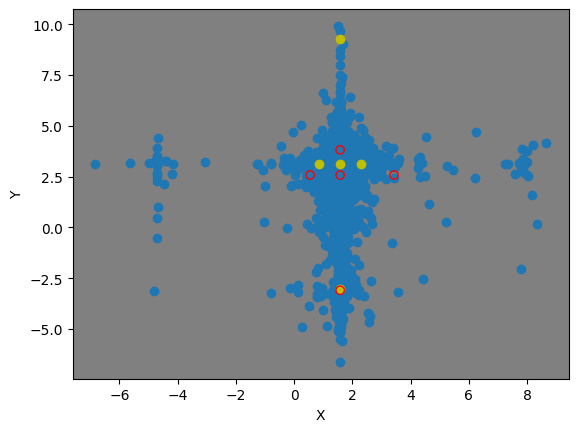

In [230]:
# Visualize
# plt.ion()
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax.set_facecolor("grey")
plot_mc = plt.scatter(mc_particles[0,:], mc_particles[1,:])
plot_foresee = plt.scatter( sigma_points[0,:], sigma_points[1,:], c = 'y' )
# plot_foresee2 = plt.scatter( full_sigma_points[0,:], full_sigma_points[1,:], c = 'k' )
plot_foresee_GenUT = plt.scatter( sigma_points_GenUT[0,:], sigma_points_GenUT[1,:], edgecolors = 'r', facecolor='none' )
# plot_foresee2_GenUT = plt.scatter( full_sigma_points_GenUT[0,:], full_sigma_points_GenUT[1,:], edgecolors = 'y', facecolor='none' )
# plot_pilco = confidence_ellipse( pilco_mu, pilco_cov, ax, n_std=3.0, edgecolor = 'red' )

# compute means
print(f" MC mean:{ np.mean(mc_particles, axis=1) } ")
print(f" UT mean:{ get_mean(sigma_points, weights  )[:,0] } ")
print(f" UT mean GenUT:{ get_mean(sigma_points_GenUT, weights_GenUT  )[:,0] } ")
print(f" UT mean full:{ get_mean(full_sigma_points, full_weights  )[:,0] } ")
print(f" UT mean full GenUT:{ get_mean(full_sigma_points_GenUT, full_weights_GenUT  )[:,0] } ")
# print(f" PILCO mean: {pilco_mu[:,0]} ")

# Compute Cov
_, mc_cov = get_mean_cov(mc_particles, np.ones((1,mc_particles.shape[1]))/mc_particles.shape[1])
_, foresee_cov = get_mean_cov( sigma_points, weights )
_, foresee_complete_cov = get_mean_cov( full_sigma_points, full_weights )
_, foresee_cov_GenUT = get_mean_cov( sigma_points_GenUT, weights_GenUT )

print(f" MC cov : \n {mc_cov}")
print(f" foresee cov : \n {foresee_cov}")
print(f" foresee_complete cov : \n {foresee_complete_cov}")
print(f" foresee cov GenUT : \n {foresee_cov_GenUT}")
# print(f" pilco cov : \n {pilco_cov}")

 MC mean:[0.37460181 0.38022978] 
 UT mean:[0.37793714 0.37793714] 
 UT mean full:[0.37793714 0.37793714] 
 MC cov : 
 [[ 0.12590282 -0.00058923]
 [-0.00058923  0.12771575]]
 foresee cov : 
 [[ 1.31307474e-01 -9.61613023e-34]
 [-7.70371978e-34  1.31307474e-01]]
 foresee_complete cov : 
 [[ 1.31307474e-01 -2.72512902e-06]
 [-2.72512902e-06  1.31307474e-01]]


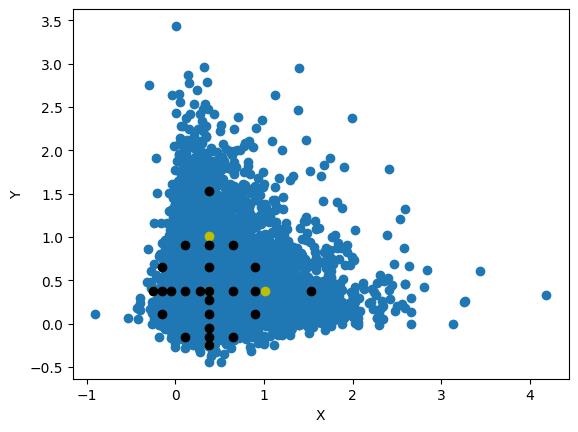

In [115]:
# Visualize
# plt.ion()
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel("X")
ax.set_ylabel("Y")

plot_mc = plt.scatter(mc_particles[0,:], mc_particles[1,:])
plot_foresee = plt.scatter( sigma_points[0,:], sigma_points[1,:], c = 'y' )
plot_foresee2 = plt.scatter( full_sigma_points[0,:], full_sigma_points[1,:], c = 'k' )
# plot_pilco = confidence_ellipse( pilco_mu, pilco_cov, ax, n_std=3.0, edgecolor = 'red' )

# compute means
print(f" MC mean:{ np.mean(mc_particles, axis=1) } ")
print(f" UT mean:{ get_mean(sigma_points, weights  )[:,0] } ")
print(f" UT mean full:{ get_mean(full_sigma_points, full_weights  )[:,0] } ")
# print(f" PILCO mean: {pilco_mu[:,0]} ")

# Compute Cov
_, mc_cov = get_mean_cov(mc_particles, np.ones((1,mc_particles.shape[1]))/mc_particles.shape[1])
_, foresee_cov = get_mean_cov( sigma_points, weights )
_, foresee_complete_cov = get_mean_cov( full_sigma_points, full_weights )

print(f" MC cov : \n {mc_cov}")
print(f" foresee cov : \n {foresee_cov}")
print(f" foresee_complete cov : \n {foresee_complete_cov}")
# print(f" pilco cov : \n {pilco_cov}")

In [16]:
full_sigma_points

array([[ -2.6692638 , -11.2366849 ,   5.8981573 ,  -2.6692638 ,
         -2.6692638 ,   2.42046929,  -5.22794151,  10.0688801 ,
          2.42046929,   2.42046929,  20.58596713,  12.63925654,
         28.53267772,  20.58596713,  20.58596713,  -2.6692638 ,
        -11.2366849 ,   5.8981573 ,  -2.6692638 ,  -2.6692638 ,
         -2.6692638 , -11.2366849 ,   5.8981573 ,  -2.6692638 ,
         -2.6692638 ],
       [ -2.6692638 ,  -2.6692638 ,  -2.6692638 , -11.2366849 ,
          5.8981573 ,  -2.6692638 ,  -2.6692638 ,  -2.6692638 ,
        -11.2366849 ,   5.8981573 ,  -2.6692638 ,  -2.6692638 ,
         -2.6692638 , -11.2366849 ,   5.8981573 ,   2.42046929,
          2.42046929,   2.42046929,  -5.22794151,  10.0688801 ,
         20.58596713,  20.58596713,  20.58596713,  12.63925654,
         28.53267772]])